In [213]:
import os
SUICIDE_PATH = os.path.join('datasets', 'suicide')

import pandas as pd
def load_suicide_data(suicide_path=SUICIDE_PATH):
    csv_path = os.path.join(suicide_path, 'master.csv')
    return pd.read_csv(csv_path)

suicide = load_suicide_data()
suicide.head()

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers


In [214]:
suicide.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27820 entries, 0 to 27819
Data columns (total 12 columns):
country               27820 non-null object
year                  27820 non-null int64
sex                   27820 non-null object
age                   27820 non-null object
suicides_no           27820 non-null int64
population            27820 non-null int64
suicides/100k pop     27820 non-null float64
country-year          27820 non-null object
HDI for year          8364 non-null float64
 gdp_for_year ($)     27820 non-null object
gdp_per_capita ($)    27820 non-null int64
generation            27820 non-null object
dtypes: float64(2), int64(4), object(6)
memory usage: 1.9+ MB


In [215]:
#rename columns
suicide.columns = ['country', 'year', 'sex', 'age', 'suicides_no', 'population', 'suicides_per_100k_pop', 'country_year',
                   'hdi', 'gdp', 'gdp_per_capita', 'generation']
#alter columns' types
suicide['country'] = suicide['country'].astype('category')
suicide['year'] = suicide['year'].astype('category')
suicide['sex'] = suicide['sex'].astype('category')
suicide['age'] = suicide['age'].astype('category')
suicide['country_year'] = suicide['country_year'].astype('category')
suicide['generation'] = suicide['generation'].astype('category')
suicide['gdp'] = suicide['gdp'].astype(str)
suicide['gdp'] = suicide.iloc[:,-3].str.replace(",", "").astype(float)

In [216]:
suicide.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27820 entries, 0 to 27819
Data columns (total 12 columns):
country                  27820 non-null category
year                     27820 non-null category
sex                      27820 non-null category
age                      27820 non-null category
suicides_no              27820 non-null int64
population               27820 non-null int64
suicides_per_100k_pop    27820 non-null float64
country_year             27820 non-null category
hdi                      8364 non-null float64
gdp                      27820 non-null float64
gdp_per_capita           27820 non-null int64
generation               27820 non-null category
dtypes: category(6), float64(3), int64(3)
memory usage: 1.5 MB


In [217]:
suicide.describe()

,suicides_no,population,suicides_per_100k_pop,hdi,gdp,gdp_per_capita
count,27820.000000,2.782000e+04,27820.000000,8364.000000,2.782000e+04,27820.000000
mean,242.574407,1.844794e+06,12.816097,0.776601,4.455810e+11,16866.464414
std,902.047917,3.911779e+06,18.961511,0.093367,1.453610e+12,18887.576472
min,0.000000,2.780000e+02,0.000000,0.483000,4.691962e+07,251.000000
25%,3.000000,9.749850e+04,0.920000,0.713000,8.985353e+09,3447.000000
50%,25.000000,4.301500e+05,5.990000,0.779000,4.811469e+10,9372.000000
75%,131.000000,1.486143e+06,16.620000,0.855000,2.602024e+11,24874.000000
max,22338.000000,4.380521e+07,224.970000,0.944000,1.812071e+13,126352.000000


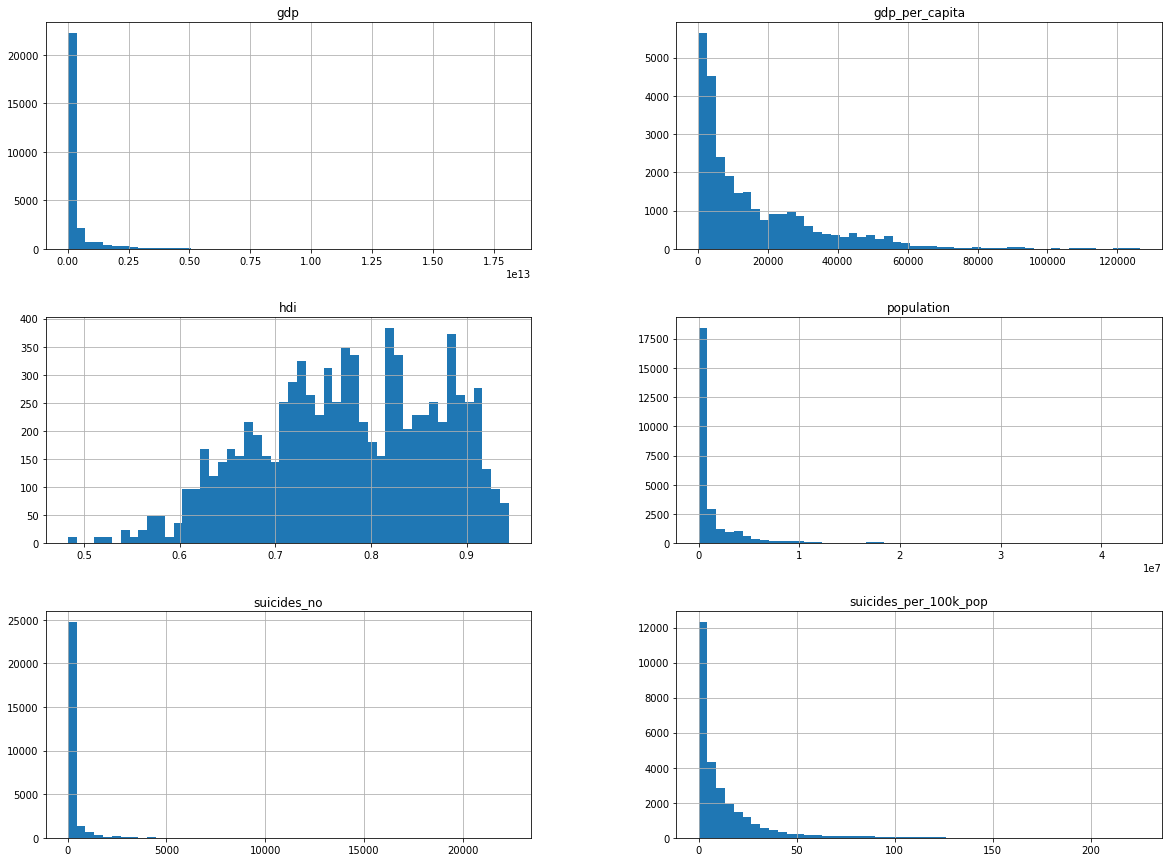

In [218]:
%matplotlib inline

import matplotlib.pyplot as plt

suicide.hist(bins=50, figsize=(20,15))
plt.show()

In [219]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(suicide, suicide['country_year']):
    strat_train_set = suicide.loc[train_index]
    strat_test_set = suicide.loc[test_index]

In [220]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MultiLabelBinarizer

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

class MyMultiLabelBinarizer(TransformerMixin):
    def __init__(self, *args, **kwargs):
        self.encoder = MultiLabelBinarizer(*args, **kwargs)
    def fit(self, x, y=0):
        self.encoder.fit(x)
        return self
    def transform(self, x, y=0):
        return self.encoder.transform(x)

In [221]:
num_attribs = ['suicides_per_100k_pop', 'hdi', 'gdp_per_capita']
cat_attribs = ['country', 'year', 'sex', 'age']

In [222]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler()),
])

from sklearn.preprocessing import FunctionTransformer
def cast_string(X):
    return X.astype(str)

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('cast_string', FunctionTransformer(cast_string, validate=False)),
    ('label_binarizer', MyMultiLabelBinarizer()),
])

from sklearn.pipeline import FeatureUnion
full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline)
])

In [223]:
data = strat_train_set.drop('suicides_no', axis=1)
data_labels = strat_train_set['suicides_no'].copy()

test_data = strat_test_set.iloc[:4]
test_labels = strat_test_set['suicides_no'].copy().iloc[:4]

data_prepared = full_pipeline.fit_transform(data)
data_prepared

array([[ 3.68776886e-01,  1.57446958e-02, -4.56897798e-01, ...,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [-6.21279599e-01,  1.73326879e+00,  5.85265692e-01, ...,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [-6.63320214e-01,  1.57446958e-02, -8.31849636e-01, ...,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       ...,
       [ 1.97251918e-03,  2.67010011e+00,  1.68200910e+00, ...,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [-6.62269199e-01,  1.57446958e-02, -8.55718405e-01, ...,
         1.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [ 9.07833185e-02,  1.57446958e-02, -8.49936859e-01, ...,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [224]:
data_prepared.shape

(22256, 144)

In [225]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(data_prepared, data_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [226]:
some_data = data.iloc[:5]
some_labels = data_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [ -53.3125 -249.3125   55.4375  -72.     -245.375 ]
Labels: [9, 6, 21, 0, 7]


In [227]:
import numpy as np
from sklearn.metrics import mean_squared_error

data_line_predictions = lin_reg.predict(data_prepared)
lin_mse = mean_squared_error(data_labels, data_line_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

645.5555641435918

In [228]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(data_prepared, data_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [229]:
data_tree_predictions = tree_reg.predict(data_prepared)
tree_mse = mean_squared_error(data_labels, data_tree_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [230]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, data_prepared, data_labels,
    scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [231]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [232]:
display_scores(tree_rmse_scores)

Scores: [ 70.23712884 100.89827459  82.44862813  82.20687806 113.38705587
 107.01406605  90.28763027  92.35052666  70.76939604  76.10947762]
Mean: 88.5709062129208
Standard deviation: 14.182664117820337


In [233]:
lin_scores = cross_val_score(lin_reg, data_prepared, data_labels,
    scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [502.63185523 600.72607498 638.58587738 688.90485554 722.42797812
 517.91482727 684.68588312 730.8711459  653.13459405 713.02087084]
Mean: 645.2903962433487
Standard deviation: 77.44957683603027


In [234]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(data_prepared, data_labels)

data_forest_predictions = forest_reg.predict(data_prepared)

print("Predictions:", data_forest_predictions)
print("Labels:", list(some_labels))

forest_mse = mean_squared_error(data_labels, data_forest_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

d:\programs\python\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Predictions: [  8.7   6.5  20.2 ... 630.1   7.    8.7]
Labels: [9, 6, 21, 0, 7]


52.35437734080456

In [235]:
forest_scores = cross_val_score(forest_reg, data_prepared, data_labels,
    scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [68.43966247 78.0397986  96.63777415 74.45251805 93.00631272 87.15324095
 79.36334968 90.90619393 86.77369725 82.85407861]
Mean: 83.76266264033751
Standard deviation: 8.34990857423433


In [236]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
    scoring='neg_mean_squared_error')

grid_search.fit(data_prepared, data_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [237]:
final_model = grid_search.best_estimator_
X_test = strat_test_set.drop('suicides_no', axis=1)
y_test = strat_test_set['suicides_no'].copy()
X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

print("Final Predictions:")
print(final_predictions)
print("Final MSE: ", final_mse)
print("Final RMSE: ", final_rmse)

Final Predictions:
[1019.2           2.46666667    3.73333333 ...  461.8         458.13333333
   30.2       ]
Final MSE:  70047.5507595233
Final RMSE:  264.66497833964223
